CMSC320, Project 3
Brad Chessin
Erin Estes
Brian Scheff

***Note for grader of this project. You may need to follow this tutorial to install the Google API for Python: https://developers.google.com/api-client-library/python/start/installation

**Also we personally created a Google BigQuery project in the API and passed in the project_id here. It was the only way to get this data.

In this project we are analyzing the NOAA data set which we originally found here: https://catalog.data.gov/dataset/u-s-daily-climate-normals-1981-2010

After browsing their website, we came across their suite of data on Google BigQuery of environmental and climatic data from 1929-2017. This data set includes "meteorological parameters for thousands of U.S. stations located across the 50 states, as well as U.S. territories, commonwealths, the Compact of Free Association nations, and one station in Canada." Such data can include: temperature, air pressure, preciptation, severe weather events, Wind Speed, Dew Point, etc...

For this project we include intervals of 10 years starting at 1929 and going until 2017 (note: we go from 2009 to 2017 even though that is not a 10 year interval - just so we can see the most recent data as well).

As another note, we include sample sizes of 2000 from each of the year intervals because otherwise our data would be too big for Jupyter to handle. So the code below essentially queries Google BigQuery's API and processes them all into one large data frame of 20,000 rows containing all of data. We will do some post processing afterwards. 

***Note: There are more columns in this dataFrame than Pandas can show. A full list of the columns and their data is included here in the bottom table (under "Table Details"): https://bigquery.cloud.google.com/table/bigquery-public-data:noaa_gsod.gsod1929?tab=schema

In [1]:
import pandas as pd
from pandas.io import gbq
import sklearn
from scipy.stats import mstats
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

dataFrame = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1929] LIMIT 2000", project_id="finalproject-167316")

dF2 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1939] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF2)

dF3 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1949] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF3)

dF4 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1959] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF4)

dF5 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1969] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF5)

dF55 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1979] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF55)

dF6 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1989] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF6)

dF7 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod1999] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF7)

dF8 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod2009] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF8)

dF9 = gbq.read_gbq("SELECT * FROM [bigquery-public-data:noaa_gsod.gsod2017] LIMIT 2000", project_id="finalproject-167316")
dataFrame = dataFrame.append(dF9)

dataFrame = dataFrame.rename(columns={'stn': 'Station Number'
                        , 'year': 'Year'
                        , 'mo': 'Month'
                        , 'da': 'Day'
                        , 'temp': 'Temperature'
                        , 'dewp': 'Dew Point'
                        , 'slp': 'Sea Level Pressure'
                        , 'stp': 'Station Pressure'
                        , 'wdsp': 'Wind Speed'
                        , 'mxpsd': 'Max Wind Speed'
                        , 'max': 'Maximum Temperature'
                        , 'min': 'Minimum Temperature'
                        , 'prcp': 'Daily Preciptation'
                        , 'sndp': 'Snow Accumulation'})
dataFrame = dataFrame.drop('wban', 1)

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 2000 rows.

Total time taken 2.02 s.
Finished at 2017-05-14 15:51:25.
Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 2000 rows.

Total time taken 1.52 s.
Finished at 2017-05-14 15:51:27.
Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 2000 rows.

Total time taken 1.57 s.
Finished at 2017-05-14 15:51:28.
Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 2000 rows.

Total time taken 1.59 s.
Finished at 2017-05-14 15:51:30.
Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 2000 rows.

Total time taken 1.77 s.
Finished at 2017-05-14 15:51:32.
Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 2000 rows.

Total time taken 1.51 s.
Finished at 2017-05-14 15:51:33.
Requesting query... ok.
Query runn

We want to ensure that viewers of this data do not confuse the "99.99" for Daily Precipitation and "999.9" for Snow Accumulation as actual data. These essentially mean there was no preciptation or accumulation on that given day so we do some post-processing here and set them to 0.0 each respectively. 

In [2]:
dataFrame = dataFrame.replace(99.9, 0.0)
dataFrame = dataFrame.replace(99.99, 0.0)
dataFrame = dataFrame.replace(999.9, 0.0)
dataFrame = dataFrame.replace(999.99, 0.0)
dataFrame = dataFrame.replace(9999.9, 0.0)
dataFrame = dataFrame.replace(9999.99, 0.0)

#Make severe weather columns with string data types -> convert to integers
dataFrame['tornado_funnel_cloud'] = dataFrame['tornado_funnel_cloud'].astype(np.int64).fillna(0)
dataFrame['hail'] = dataFrame['hail'].astype(np.int64).fillna(0)
dataFrame['thunder'] = dataFrame['thunder'].astype(np.int64).fillna(0)

dataFrame

,Station Number,Year,Month,Day,Temperature,count_temp,Dew Point,count_dewp,Sea Level Pressure,count_slp,...,flag_min,Daily Preciptation,flag_prcp,Snow Accumulation,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,030050,1929,10,01,45.3,4,40.0,4,1001.6,4,...,*,0.00,I,0.0,0,0,0,0,0,0
1,030050,1929,10,02,49.5,4,45.2,4,977.6,4,...,None,0.00,None,0.0,0,1,0,0,0,0
2,030050,1929,10,03,49.0,4,41.7,4,975.7,4,...,None,0.00,None,0.0,0,1,0,0,0,0
3,030050,1929,10,04,45.7,4,38.5,4,992.0,4,...,None,0.00,None,0.0,0,1,0,0,0,0
4,030050,1929,10,05,46.5,4,41.5,4,997.8,4,...,None,0.00,None,0.0,0,1,0,0,0,0
5,030050,1929,10,06,49.5,4,46.5,4,990.1,4,...,None,0.00,None,0.0,0,1,0,0,0,0
6,030050,1929,10,07,48.2,4,44.8,4,979.1,4,...,None,0.00,None,0.0,0,1,0,0,0,0
7,030050,1929,10,08,46.5,4,39.2,4,994.3,4,...,None,0.00,I,0.0,0,0,0,0,0,0
8,030050,1929,10,09,44.7,4,40.0,4,1005.4,4,...,None,0.00,I,0.0,0,0,0,0,0,0
9,030050,1929,10,10,48.7,4,47.0,4,1000.6,4,...,None,0.00,None,0.0,0,1,0,0,0,0


Now that we have our dataFrame all set and ready to go, we can start analyzing some data on it. So lets analyze the mean temperature over the course of these time intervals. We will put that into a linegraph. 

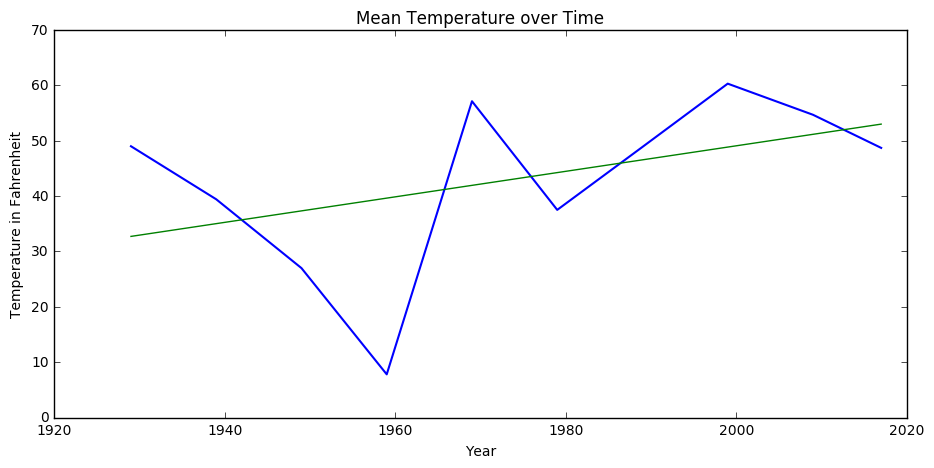

In [3]:
timeArray = ['1929', '1939', '1949', '1959', '1969', '1979', '1989', '1999', '2009', '2017']
timeArrayInt = [1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2017]

one = ma.mean(dataFrame.loc[dataFrame['Year'] == '1929', 'Temperature'])
two = ma.mean(dataFrame.loc[dataFrame['Year'] == '1939', 'Temperature'])
three = ma.mean(dataFrame.loc[dataFrame['Year'] == '1949', 'Temperature'])
four = ma.mean(dataFrame.loc[dataFrame['Year'] == '1959', 'Temperature'])
five = ma.mean(dataFrame.loc[dataFrame['Year'] == '1969', 'Temperature'])
six = ma.mean(dataFrame.loc[dataFrame['Year'] == '1979', 'Temperature'])
seven = ma.mean(dataFrame.loc[dataFrame['Year'] == '1989', 'Temperature'])
eight = ma.mean(dataFrame.loc[dataFrame['Year'] == '1999', 'Temperature'])
nine = ma.mean(dataFrame.loc[dataFrame['Year'] == '2009', 'Temperature'])
ten = ma.mean(dataFrame.loc[dataFrame['Year'] == '2017', 'Temperature'])

overallMeanArray = [one, two, three, four,
                   five, six, seven, eight, nine, ten]

x = timeArrayInt
xi = np.asarray(timeArrayInt)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,overallMeanArray)
line1 = intercept + slope*xi

overallMeanTempArray = overallMeanArray;

plt.figure(figsize=(11,5))
plt.plot(timeArray, overallMeanArray, '-b', linewidth=1.5, label='') #blue line
plt.plot(xi,line1,'g-')
plt.ylabel('Temperature in Fahrenheit')
plt.xlabel('Year')
plt.title('Mean Temperature over Time')
plt.show()

As this graph shows. The temperature took a dip around 1960 and 1980. However, the linear regression of this line shows that the temperature is in fact slowly increasing over time. While these large dips are shown here, it may just be due to our limited sample size. These weather locations are scattered around the country by random in our data set and it could be that we happened to get a bunch of colder location stations for those time periods. However, this sample should provide some insight that the temperature is in fact going over since the late 1920s.

Now lets analyze the mean wind over the course of these time intervals. We will put that into a linegraph. 

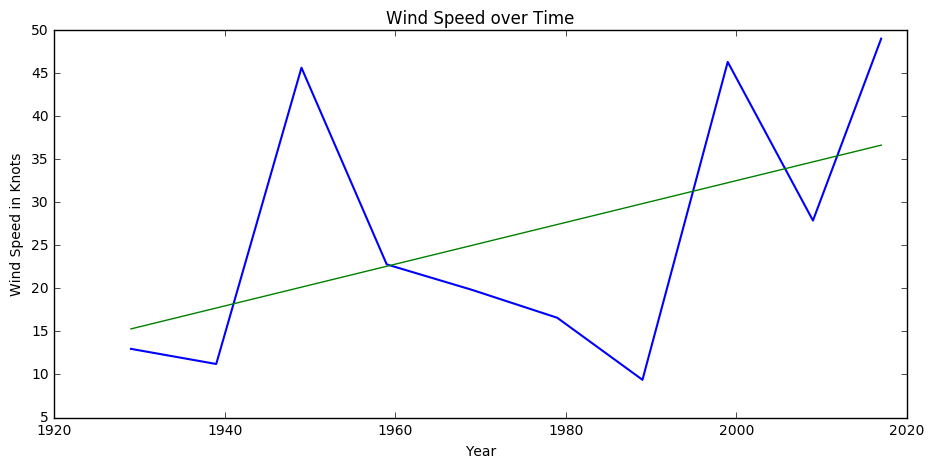

In [4]:
oneArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1929', 'Wind Speed']]
one = ma.mean(oneArr)

twoArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1939', 'Wind Speed']]
two = ma.mean(twoArr)

threeArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1949', 'Wind Speed']]
three = ma.mean(threeArr)

fourArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1959', 'Wind Speed']]
four = ma.mean(fourArr)

fiveArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1969', 'Wind Speed']]
five = ma.mean(fiveArr)

sixArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1979', 'Wind Speed']]
six = ma.mean(sixArr)

sevenArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1989', 'Wind Speed']]
seven = ma.mean(sevenArr)

eightArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '1999', 'Wind Speed']]
eight = ma.mean(eightArr)

nineArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '2009', 'Wind Speed']]
nine = ma.mean(nineArr)

tenArr = [float(i) for i in dataFrame.loc[dataFrame['Year'] == '2017', 'Wind Speed']]
ten = ma.mean(tenArr)

overallMeanArray = [one, two, three, four,
                   five, six, seven, eight, nine, ten]

x = timeArrayInt
xi = np.asarray(timeArrayInt)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,overallMeanArray)
line1 = intercept + slope*xi

overallMeanWindArray = overallMeanArray

plt.figure(figsize=(11,5))
plt.plot(timeArray, overallMeanArray, '-b', linewidth=1.5, label='') #blue line
plt.plot(xi,line1,'g-')
plt.ylabel('Wind Speed in Knots')
plt.xlabel('Year')
plt.title('Wind Speed over Time')
plt.show()

The graph above is showing the average wind spreed over time. Similarly with the temperature graph, the wind dips in 1960 and 1980 along with the mid 2000s, however in this case the graph is increasingly more powerfully over time. This shows that the wind is picking up as the years increase, and our linear regression shows that. 

We can also get precipitation over time (we will use this later in our project as well).

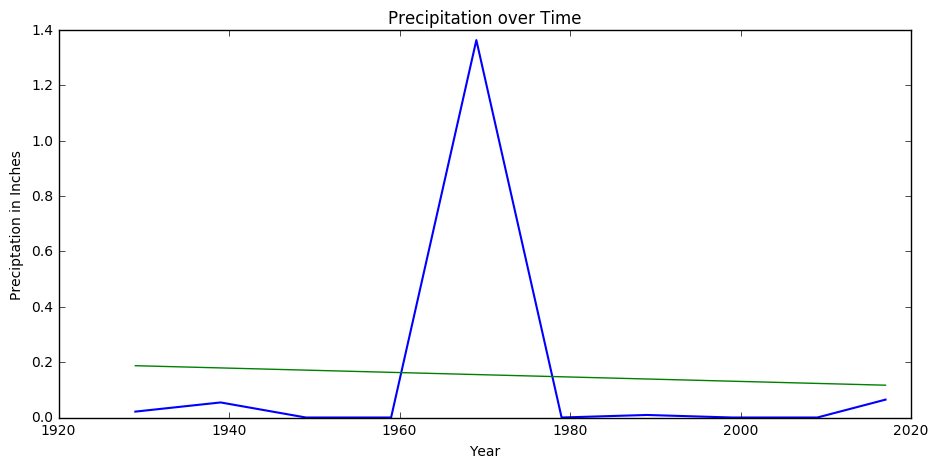

In [5]:
one = ma.mean(dataFrame.loc[dataFrame['Year'] == '1929', 'Daily Preciptation'])
two = ma.mean(dataFrame.loc[dataFrame['Year'] == '1939', 'Daily Preciptation'])
three = ma.mean(dataFrame.loc[dataFrame['Year'] == '1949', 'Daily Preciptation'])
four = ma.mean(dataFrame.loc[dataFrame['Year'] == '1959', 'Daily Preciptation'])
five = ma.mean(dataFrame.loc[dataFrame['Year'] == '1969', 'Daily Preciptation'])
six = ma.mean(dataFrame.loc[dataFrame['Year'] == '1979', 'Daily Preciptation'])
seven = ma.mean(dataFrame.loc[dataFrame['Year'] == '1989', 'Daily Preciptation'])
eight = ma.mean(dataFrame.loc[dataFrame['Year'] == '1999', 'Daily Preciptation'])
nine = ma.mean(dataFrame.loc[dataFrame['Year'] == '2009', 'Daily Preciptation'])
ten = ma.mean(dataFrame.loc[dataFrame['Year'] == '2017', 'Daily Preciptation'])

overallMeanArray = [one, two, three, four,
                   five, six, seven, eight, nine, ten]

x = timeArrayInt
xi = np.asarray(timeArrayInt)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,overallMeanArray)
line1 = intercept + slope*xi

overallPrecipMeanArray = overallMeanArray

plt.figure(figsize=(11,5))
plt.plot(timeArray, overallMeanArray, '-b', linewidth=1.5, label='') #blue line
plt.plot(xi,line1,'g-')
plt.ylabel('Preciptation in Inches')
plt.xlabel('Year')
plt.title('Precipitation over Time')
plt.show()

This graph is certainly interesting. It is plotting the mean preciptation over time however it jumps exponentially between 1960 and 1980. This could mean two things: 1. Either the sample we choose for 1959-1979 were in more precipitous regions or 2. There was some widespread weather event for the course of 20 years that caused more rainfall/snowfall to happen between that time period. Regardless, the precipitation during the other time periods was relatively consistent, however has been picking up slightly since 2009. 

Has there been an increase in severe weather since 1929? This graph will include tornados, hail, and thunder.

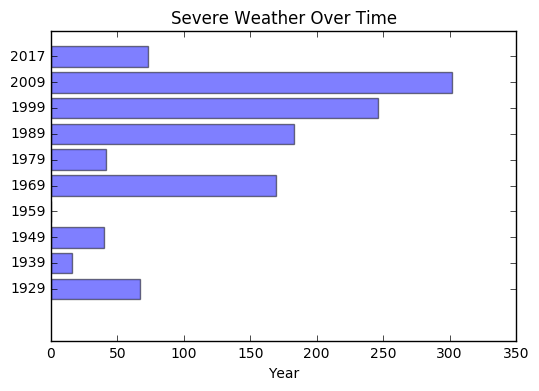

In [6]:
severeWeatherCountsByYear = []

severeWeather1929 = []
severeWeather1929.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1929', 'tornado_funnel_cloud']))
severeWeather1929.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1929', 'hail']))
severeWeather1929.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1929', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1929)])

severeWeather1939 = []
severeWeather1939.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1939', 'tornado_funnel_cloud']))
severeWeather1939.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1939', 'hail']))
severeWeather1939.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1939', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1939)])

severeWeather1949 = []
severeWeather1949.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1949', 'tornado_funnel_cloud']))
severeWeather1949.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1949', 'hail']))
severeWeather1949.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1949', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1949)])

severeWeather1959 = []
severeWeather1959.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1959', 'tornado_funnel_cloud']))
severeWeather1959.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1959', 'hail']))
severeWeather1959.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1959', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1959)])

severeWeather1969 = []
severeWeather1969.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1969', 'tornado_funnel_cloud']))
severeWeather1969.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1969', 'hail']))
severeWeather1969.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1969', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1969)])

severeWeather1979 = []
severeWeather1979.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1979', 'tornado_funnel_cloud']))
severeWeather1979.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1979', 'hail']))
severeWeather1979.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1979', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1979)])

severeWeather1989 = []
severeWeather1989.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1989', 'tornado_funnel_cloud']))
severeWeather1989.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1989', 'hail']))
severeWeather1989.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1989', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1989)])

severeWeather1999 = []
severeWeather1999.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1999', 'tornado_funnel_cloud']))
severeWeather1999.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1999', 'hail']))
severeWeather1999.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '1999', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather1999)])

severeWeather2009 = []
severeWeather2009.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '2009', 'tornado_funnel_cloud']))
severeWeather2009.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '2009', 'hail']))
severeWeather2009.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '2009', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather2009)])

severeWeather2017 = []
severeWeather2017.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '2017', 'tornado_funnel_cloud']))
severeWeather2017.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '2017', 'hail']))
severeWeather2017.append(ma.sum(dataFrame.loc[dataFrame['Year'] == '2017', 'thunder']))
severeWeatherCountsByYear.append([ma.sum(severeWeather2017)])

severeWeatherCountsByYear = sum(severeWeatherCountsByYear, [])

y_pos = np.arange(len(timeArray))
performance = severeWeatherCountsByYear

overallSevereWeatherMeanArray = severeWeatherCountsByYear
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, timeArray)
plt.xlabel('Year')
plt.title('Severe Weather Over Time')
 
plt.show()

This code and graph's goal is to break down severe weather events such as hail, thunder, tornados since 1929. The idea is to see whether or not there was a time period in which severe weather increased or decreased. As our graph shows, the total number of severe weather events has increased over time. 2009 clearly had the most severe weather events and the reason 2017's is small is because it only includes data up until early May. 

This is interesting though, this could perhaps mean that severe weather events are correlated with the temperature and wind speed increased since 2009 as well. Therefore, it is possible there is some sort of connection between these two variables. 

Has any particular month been known to have more severe weather than the rest? Show a bar graph for each month based upon specific months

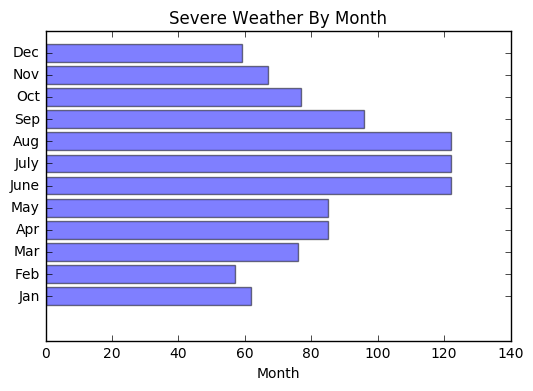

In [7]:
severeWeatherCountsByMonth = []

severeWeatherJan = []
severeWeatherJan.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '01', 'tornado_funnel_cloud']))
severeWeatherJan.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '01', 'hail']))
severeWeatherJan.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '01', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherJan)])

severeWeatherFeb = []
severeWeatherFeb.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '02', 'tornado_funnel_cloud']))
severeWeatherFeb.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '02', 'hail']))
severeWeatherFeb.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '02', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherFeb)])

severeWeatherMar = []
severeWeatherMar.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '03', 'tornado_funnel_cloud']))
severeWeatherMar.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '03', 'hail']))
severeWeatherMar.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '03', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherMar)])

severeWeatherApr = []
severeWeatherApr.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '04', 'tornado_funnel_cloud']))
severeWeatherApr.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '04', 'hail']))
severeWeatherApr.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '04', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherApr)])

severeWeatherMay = []
severeWeatherMay.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '05', 'tornado_funnel_cloud']))
severeWeatherMay.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '05', 'hail']))
severeWeatherMay.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '05', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherApr)])

severeWeatherJune = []
severeWeatherJune.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'tornado_funnel_cloud']))
severeWeatherJune.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'hail']))
severeWeatherJune.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherJune)])

severeWeatherJuly = []
severeWeatherJuly.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'tornado_funnel_cloud']))
severeWeatherJuly.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'hail']))
severeWeatherJuly.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherJuly)])

severeWeatherAug = []
severeWeatherAug.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'tornado_funnel_cloud']))
severeWeatherAug.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'hail']))
severeWeatherAug.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '06', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherAug)])

severeWeatherSep = []
severeWeatherSep.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '09', 'tornado_funnel_cloud']))
severeWeatherSep.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '09', 'hail']))
severeWeatherSep.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '09', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherSep)])

severeWeatherOct = []
severeWeatherOct.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '10', 'tornado_funnel_cloud']))
severeWeatherOct.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '10', 'hail']))
severeWeatherOct.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '10', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherOct)])

severeWeatherNov = []
severeWeatherNov.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '11', 'tornado_funnel_cloud']))
severeWeatherNov.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '11', 'hail']))
severeWeatherNov.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '11', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherNov)])

severeWeatherDec = []
severeWeatherDec.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '12', 'tornado_funnel_cloud']))
severeWeatherDec.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '12', 'hail']))
severeWeatherDec.append(ma.sum(dataFrame.loc[dataFrame['Month'] == '12', 'thunder']))
severeWeatherCountsByMonth.append([ma.sum(severeWeatherDec)])


severeWeatherCountsByMonth = sum(severeWeatherCountsByMonth, [])

monthArray = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_pos = np.arange(len(monthArray))
performance = severeWeatherCountsByMonth
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, monthArray)
plt.xlabel('Month')
plt.title('Severe Weather By Month')
 
plt.show()

The goal of this code and graph is to show during which months severe weather typically happens. This is useful because it will reflect the overall climate that these weather stations are located in. As these NOAA stations are located in the United States and Canada, it makes sense that there are more severe weather events in the summer months of June, July, and August as that is typically when these events occur.

Then the severe weather drops by 25-50% when it is fall or winter months. 

What has been the distribution of these severe weather events? Are any more common than another? This pie chart will show us all severe weather events since 1929 to present with our data set intervals.

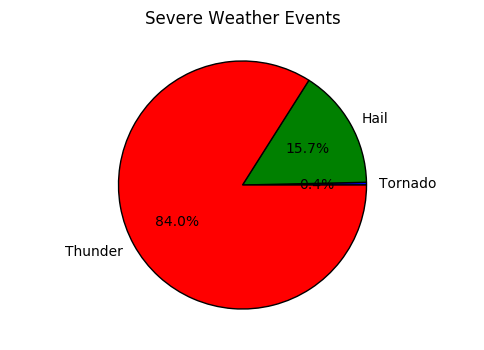

In [8]:
import matplotlib.pyplot as pyplot

tfcArr = [float(i) for i in dataFrame['tornado_funnel_cloud']]
tornadosSum = np.sum(tfcArr)

hailArr = [float(i) for i in dataFrame['hail']]
hailSum = np.sum(hailArr)

thunArr = [float(i) for i in dataFrame['thunder']]
thunderSum = np.sum(thunArr)

totalCount = tornadosSum + hailSum + thunderSum

x_list = [tornadosSum, hailSum, thunderSum]
label_list = ["Tornado", "Hail", "Thunder"]

pyplot.axis("equal")
pyplot.pie(
        x_list,
        labels=label_list,
        autopct="%1.1f%%"
        )
pyplot.title("Severe Weather Events")
pyplot.show()

Now that we analyzed the severe weather events by time, lets break hail, tornados, and thunder down and see which is the most common since 1929. From the looks of this pie graph, it is clear that thunder related events are the most prevalent at 84% while hail and tornados account for the minority.

As tornados are a rare severe weather event and only occur in midwestern/flat land areas, the weather station would have to be in such area to report such an event which makes sense why it accounts for only 0.4% of the total number of severe weather events overall. 

While this data set doesn't provide us a location in the country of each weather station is located (and only provides us with a station id number), it more than likely that midwestern weather stations would report more severe weather events (such as hail and tornados specifically) than stations in other areas.

Now what we will do is take 5 different variables, put them all in one line graph and see if there is any sort of correlation between any of them.

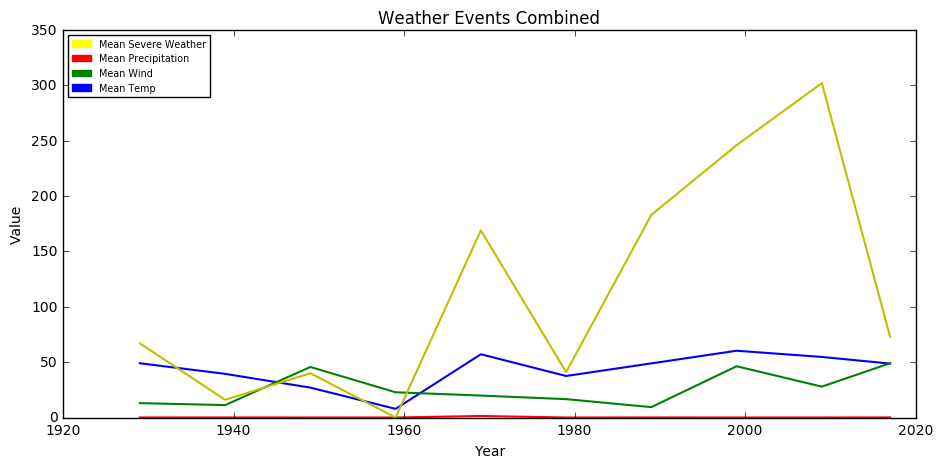

In [14]:
import matplotlib.patches as mpatches

plt.figure(figsize=(11,5))

plt.plot(timeArray, overallMeanTempArray, '-b', linewidth=1.5, label='')
plt.plot(timeArray, overallMeanWindArray, '-g', linewidth=1.5, label='')
plt.plot(timeArray, overallPrecipMeanArray, '-r', linewidth=1.5, label='') 
plt.plot(timeArray, overallSevereWeatherMeanArray, '-y', linewidth=1.5, label='')

yellow_patch = mpatches.Patch(color='yellow', label='Mean Severe Weather')
red_patch = mpatches.Patch(color='red', label='Mean Precipitation')
green_patch = mpatches.Patch(color='green', label='Mean Wind')
blue_patch = mpatches.Patch(color='blue', label='Mean Temp')

plt.legend(handles=[yellow_patch,red_patch,green_patch,blue_patch], loc=0, fontsize = 'x-small')

plt.ylabel('Value')
plt.xlabel('Year')
plt.title('Weather Events Combined')
plt.show()

This code and line graphs goal is to lead us into the statistical analysis of this project. We want to see whether or not there is a correlation between temperature, wind, preciptation, and severe weather. So by putting all the averages over time in one graph, it makes it much easier to see whether this is a correlation.

From a quick (non-numerical) analysis, it appears that temperature, wind, and severe, weather events are all somewhat correlated. It is important to note though, the severe weather line here is the SUM of the weather events for a particular year rather than the average. We would rather see the sum rather than the averages since the averages would be too low to see in a graph otherwise.